In [179]:
from google.colab import files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='darkgrid')
plt.style.use('ggplot')
%matplotlib inline

In [180]:
 #files.upload()
asthma = pd.read_csv('U.S._Chronic_Disease_Indicators__Asthma.csv')

 #files.upload()
PM2_5 = pd.read_csv('Daily_Census_Tract-Level_PM2.5_Concentrations__2011-2014_4.csv')

# files.upload()
states = pd.read_csv('states.csv')
state_fips_code = pd.read_csv('https://gist.githubusercontent.com/dantonnoriega/bf1acd2290e15b91e6710b6fd3be0a53/raw/11d15233327c8080c9646c7e1f23052659db251d/us-state-ansi-fips.csv')

#Data cleaning

First, we take a look at the pertinent raw data:

In [181]:
# Statistics pertaining to asthma for each state in each year
asthma.head(10)

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,ResponseID,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3
0,2012,2012,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,37.0,37.0,NaN,NaN,NaN,NaN,Gender,Female,NaN,NaN,NaN,NaN,NaN,1,AST,AST4_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
1,2014,2014,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,22.0,22.0,NaN,NaN,NaN,NaN,Gender,Male,NaN,NaN,NaN,NaN,NaN,1,AST,AST4_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
2,2011,2011,AZ,Arizona,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,29.0,29.0,NaN,NaN,NaN,NaN,Gender,Male,NaN,NaN,NaN,NaN,NaN,4,AST,AST4_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
3,2015,2015,CT,Connecticut,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,34.0,34.0,NaN,NaN,NaN,NaN,Gender,Female,NaN,NaN,NaN,NaN,NaN,9,AST,AST4_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
4,2011,2011,FL,Florida,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,54.0,54.0,NaN,NaN,NaN,NaN,Gender,Male,NaN,NaN,NaN,NaN,NaN,12,AST,AST4_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN
5,2015,2015,FL,Florida,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,95.0,95.0,NaN,NaN,NaN,NaN,Race/Ethnicity,"White, non-Hispanic",NaN,NaN,NaN,NaN,NaN,12,AST,AST4_1,NMBR,RACE,WHT,NaN,NaN,NaN,NaN
6,2011,2011,HI,Hawaii,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,26.0,26.0,NaN,NaN,NaN,NaN,Overall,Overall,NaN,NaN,NaN,NaN,NaN,15,AST,AST4_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
7,2013,2013,HI,Hawaii,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,24.0,24.0,NaN,NaN,NaN,NaN,Overall,Overall,NaN,NaN,NaN,NaN,NaN,15,AST,AST4_1,NMBR,OVERALL,OVR,NaN,NaN,NaN,NaN
8,2012,2012,IA,Iowa,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,22.0,22.0,NaN,NaN,NaN,NaN,Gender,Female,NaN,NaN,NaN,NaN,NaN,19,AST,AST4_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN
9,2013,2013,IA,Iowa,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,29.0,29.0,NaN,NaN,NaN,NaN,Race/Ethnicity,"White, non-Hispanic",NaN,NaN,NaN,NaN,NaN,19,AST,AST4_1,NMBR,RACE,WHT,NaN,NaN,NaN,NaN


In [182]:
# Average predicted PM2.5 (particulate matter with diameter ≤2.5 µm) concentrations, in µg/m^3, for each state in each year
PM2_5.head()

,statefips,year,ds_pm_pred,ds_pm_stdd
0,1,2011,10.696324,3.159462
1,1,2012,10.396601,4.228621
2,1,2013,10.039805,4.201070
3,1,2014,11.007064,5.885860
4,10,2011,9.671609,2.614125


In order to use these data sets to answer our research questions, we do the following data cleaning actions:

1. Dataset #1: U.S. asthma statistics
  * Merge with the `states` DataFrame to be able to group by region.
  * Select rows with age adjusted asthma prevalence.
  * Remove `NaN` values where we do not have age adjusted asthma prevalence.

2. Dataset #2: PM2.5 concentrations
  * Before importing into this notebook, we aggregated the data using an API on the CDC website in order to save time and space. We aggregated by state and year.
  * Not all 50 states are accounted for, crossreferenced and found that we were missing HI and AK (no problems there)


The distribution of the asthma prevalence data is reported from 2010-2019
PM2.5 concentration data have a huge right tail (a large nunmber of datapoints with low values and some values with extremely high values )

We will need to clean and modify these data sets in order to be able to use them to answer our research questions. We start with the asthma statistics DataFrame, `asthma`. The `states` DataFrame, which we loaded along with the relevant data, contains the state abbreviations and regions for each state (for the `asthma` dataset, Washington DC is counted as its own state): 

In [183]:
states.head()

,State,State Code,Region,Division
0,Alaska,AK,West,Pacific
1,Alabama,AL,South,East South Central
2,Arkansas,AR,South,West South Central
3,Arizona,AZ,West,Mountain
4,California,CA,West,Pacific


We will merge this DataFrame with the `asthma` DataFrame so that, later on, we can do grouping by region:

In [184]:
asthma_states = asthma.merge(states, left_on='LocationAbbr', right_on='State Code')
asthma_states.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,ResponseID,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3,State,State Code,Region,Division
0,2012,2012,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,37.0,37.0,NaN,NaN,NaN,NaN,Gender,Female,NaN,NaN,NaN,NaN,NaN,1,AST,AST4_1,NMBR,GENDER,GENF,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central
1,2014,2014,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,22.0,22.0,NaN,NaN,NaN,NaN,Gender,Male,NaN,NaN,NaN,NaN,NaN,1,AST,AST4_1,NMBR,GENDER,GENM,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central
2,2015,2015,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,NaN,Number,26.0,26.0,NaN,NaN,NaN,NaN,Race/Ethnicity,"White, non-Hispanic",NaN,NaN,NaN,NaN,NaN,1,AST,AST4_1,NMBR,RACE,WHT,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central
3,2013,2013,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,"cases per 1,000,000",Crude Rate,8.7,8.7,NaN,NaN,6.3,11.7,Overall,Overall,NaN,NaN,NaN,NaN,NaN,1,AST,AST4_1,CRDRATE,OVERALL,OVR,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central
4,2016,2016,AL,Alabama,NVSS,Asthma,Asthma mortality rate,NaN,"cases per 1,000,000",Age-adjusted Rate,6.7,6.7,NaN,NaN,4.3,9.9,Race/Ethnicity,"White, non-Hispanic",NaN,NaN,NaN,NaN,NaN,1,AST,AST4_1,AGEADJRATE,RACE,WHT,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central


Next, we select rows of the DataFrame that contain statistics on overall age-adjusted asthma prevalence rates. We use the age-adjusted rates for our analysis because it accounts for population age distribution differences across different states, reducing the effect that that particular confounder has on asthma rates:

In [185]:
aap = asthma_states.query(
        'Question == "Current asthma prevalence among adults aged >= 18 years"' + 
        '& StratificationCategory1 == "Overall"' +
        '& DataValueType == "Age-adjusted Prevalence"' # Asthma prevalence is expressed as a percentage of the overall population
    )[['YearStart', 'State Code', 'Division', 'DataValue']].rename(
        columns={'YearStart': 'year',
                 'State Code': 'state',
                 'Division': 'div',
                 'DataValue': 'aap'}
    ).reset_index().drop(columns='index')
aap

,year,state,div,aap
0,2019,AL,East South Central,9.4
1,2015,AL,East South Central,9.9
2,2017,AL,East South Central,10.9
3,2013,AL,East South Central,8.5
4,2011,AL,East South Central,8.0
...,...,...,...,...
454,2016,ME,New England,12.7
455,2018,ME,New England,12.8
456,2012,ME,New England,11.3
457,2014,ME,New England,11.9


There is only one missing value in the `aap` column, so dropping it should not affect our analysis or validity of our conclusions greatly:

In [186]:
aap['aap'].isna().sum()

1

In [187]:
aap_na_removed = aap.dropna()
aap_na_removed.head()

,year,state,div,aap
0,2019,AL,East South Central,9.4
1,2015,AL,East South Central,9.9
2,2017,AL,East South Central,10.9
3,2013,AL,East South Central,8.5
4,2011,AL,East South Central,8.0


In [188]:
# It turns out the missing value is for New Jersey in 2019
aap[lambda df: df['aap'].isna()]

,year,state,div,aap
357,2019,NJ,Middle Atlantic,NaN


As a sanity check, we should have exactly 51 unique states represented in our final `aap_na_removed` DataFrame:

In [189]:
np.count_nonzero(aap_na_removed.value_counts('state'))

51

# Observed Trends:


*   New England has a marketdly higher mean (age adjusted) asthma rate than any other region
*   On its own, PM2.5 concentration does not seem heavily correlated with Asthma rates, but when we stratify for geographic region, we can see certain trends and clusters forming



# Visual #1

From this categorical visualization we can see  deviation between the means of each region and the overall mean(the red line). This image motivates us to ask, what differences are statistically significant? What regions significantly deviate from the average? This motivates our second research question.


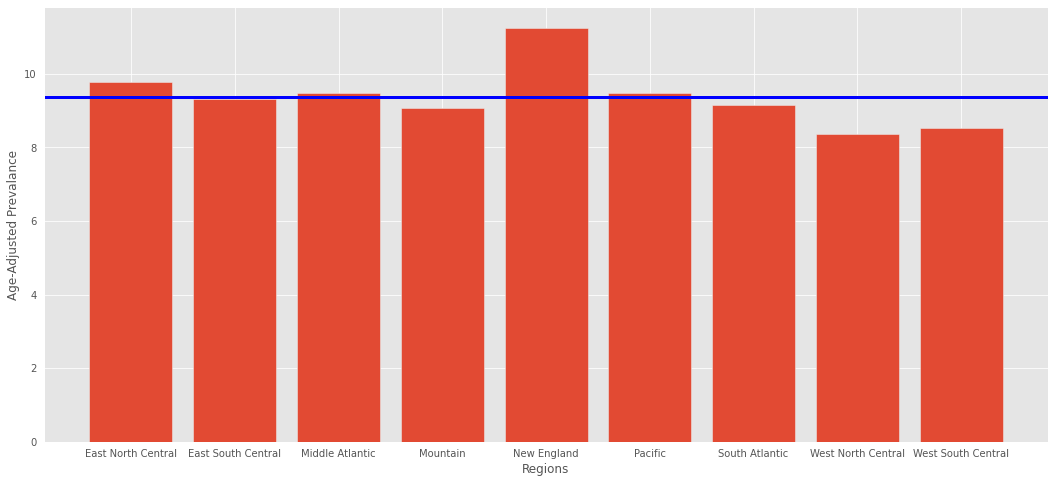

In [190]:
div_means = aap.groupby("div").mean()

plt.figure(figsize = (18,8))
plt.bar(div_means.index, div_means["aap"])
plt.xlabel("Regions")
plt.axhline(y=np.mean(div_means)[1],linewidth=3, color='b')
plt.ylabel("Age-Adjusted Prevalance");


#Data Cleaning:



1.   Dataset #1: U.S._Chronic_Disease_Indicators__Asthma.csv


*   We pick the reported asthma incidence rate of the overall population and from the year 2011 to 2014 which is of interest to our research question 
*   We then merged the asthma dataset with the PM2.5 dataset based on year and state (4 data points for each state, 49 states in total, 196 total data points)



2.   Dataset #2: Daily Census Tract-Level PM2.5 Concentrations



3.   Dataset #4: State fibs code
*   This is a data set we found on github that matches state fibs code with the name and abbreviations of the state 
*   Merge with the PM 2.5 data set to replace the state fibs code with the actual name of the state 





# Observed Trends:


*   The correlation between PM2.5 concetration and incidence of asthma in adults is pretty low (-0.05)
*   When you color the scatter plot of PM 2.5 concetration and incidence asthma based on large divisions of region, we can see that states within the same region seem to be grouped together. (eg: the mountain region/ the new England region seem to be clustered together)

In [191]:
state_fips_code.columns

Index(['stname', ' st', ' stusps'], dtype='object')

In [192]:
PM_2point5 = PM2_5.merge(state_fips_code, left_on="statefips", right_on=" st")

In [193]:
PM_2point5.drop(["statefips", " st"], axis = 1)

,year,ds_pm_pred,ds_pm_stdd,stname,stusps
0,2011,10.696324,3.159462,Alabama,AL
1,2012,10.396601,4.228621,Alabama,AL
2,2013,10.039805,4.201070,Alabama,AL
3,2014,11.007064,5.885860,Alabama,AL
4,2011,9.671609,2.614125,Delaware,DE
...,...,...,...,...,...
191,2014,6.674491,3.114788,Colorado,CO
192,2011,9.284398,2.494633,Connecticut,CT
193,2012,8.072119,2.612901,Connecticut,CT
194,2013,8.406929,2.795787,Connecticut,CT


In [194]:
asthma_states= asthma_states.query(
        'Question == "Current asthma prevalence among adults aged >= 18 years"' + 
        '& StratificationCategory1 == "Overall"' +
        '& DataValueType == "Age-adjusted Prevalence"' # Asthma prevalence is expressed as a percentage of the overall population
    )

In [195]:
age_asthma_overall = asthma_states[asthma_states["Stratification1"] == "Overall"]
age_asthma_overall_2011_2014 = age_asthma_overall[age_asthma_overall["YearStart"].isin(["2011", "2012", "2013", "2014"])]

In [196]:
age_asthma_overall_2011_2014_select = age_asthma_overall_2011_2014[["YearStart", "LocationAbbr", "LocationDesc", "DataValue", "Division"]]

In [197]:
PM_2point5["stname"][0]

'Alabama'

In [198]:
age_asthma_overall_2011_2014_select["LocationDesc"]

463           Alabama
467           Alabama
490           Alabama
497           Alabama
1745          Arizona
             ...     
59630    South Dakota
60734           Maine
60748           Maine
60835           Maine
60848           Maine
Name: LocationDesc, Length: 204, dtype: object

In [199]:
merged = PM_2point5.merge(age_asthma_overall_2011_2014_select, left_on = ["year", "stname"], right_on =["YearStart", "LocationDesc"])

In [200]:
merged_cleaned = merged.drop([" stusps", "YearStart", "LocationDesc", " st"], axis = 1)

In [201]:
merged_cleaned

,statefips,year,ds_pm_pred,ds_pm_stdd,stname,LocationAbbr,DataValue,Division
0,1,2011,10.696324,3.159462,Alabama,AL,8.0,East South Central
1,1,2012,10.396601,4.228621,Alabama,AL,8.5,East South Central
2,1,2013,10.039805,4.201070,Alabama,AL,8.5,East South Central
3,1,2014,11.007064,5.885860,Alabama,AL,9.5,East South Central
4,10,2011,9.671609,2.614125,Delaware,DE,10.0,South Atlantic
...,...,...,...,...,...,...,...,...
191,8,2014,6.674491,3.114788,Colorado,CO,8.3,Mountain
192,9,2011,9.284398,2.494633,Connecticut,CT,10.1,New England
193,9,2012,8.072119,2.612901,Connecticut,CT,10.1,New England
194,9,2013,8.406929,2.795787,Connecticut,CT,10.0,New England


In [202]:
merged_cleaned["DataValue"].corr(merged_cleaned["ds_pm_pred"])

-0.052257042989518054

# Visual #2

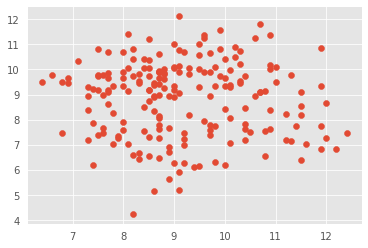

In [203]:
plt.scatter(merged_cleaned["DataValue"], merged_cleaned["ds_pm_pred"])

Text(0.5, 1.0, 'PM 2.5 concentration vs. asthma incidence colored by region')

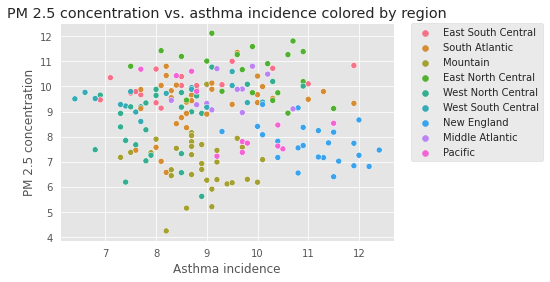

In [204]:
import seaborn as sns 
sns.scatterplot(x='DataValue',  y='ds_pm_pred', data=merged_cleaned, hue="Division")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Asthma incidence")
plt.ylabel("PM 2.5 concentration")
plt.title("PM 2.5 concentration vs. asthma incidence colored by region")

In [205]:
# Trying to control for location
merged_cleaned

,statefips,year,ds_pm_pred,ds_pm_stdd,stname,LocationAbbr,DataValue,Division
0,1,2011,10.696324,3.159462,Alabama,AL,8.0,East South Central
1,1,2012,10.396601,4.228621,Alabama,AL,8.5,East South Central
2,1,2013,10.039805,4.201070,Alabama,AL,8.5,East South Central
3,1,2014,11.007064,5.885860,Alabama,AL,9.5,East South Central
4,10,2011,9.671609,2.614125,Delaware,DE,10.0,South Atlantic
...,...,...,...,...,...,...,...,...
191,8,2014,6.674491,3.114788,Colorado,CO,8.3,Mountain
192,9,2011,9.284398,2.494633,Connecticut,CT,10.1,New England
193,9,2012,8.072119,2.612901,Connecticut,CT,10.1,New England
194,9,2013,8.406929,2.795787,Connecticut,CT,10.0,New England


In [206]:
from sklearn.linear_model import LinearRegression
X = merged_cleaned[["ds_pm_pred"]]
y = merged_cleaned[["DataValue"]]

X = np.array(X)
y = np.array(y)

reg = LinearRegression().fit(X, y)
reg.coef_

array([[-0.04494758]])

In [207]:
# Trying to add division as one-hot (controlling for geo-location)
division = pd.get_dummies(merged_cleaned["Division"])
X_geo = pd.concat([merged_cleaned["ds_pm_pred"], division], axis = 1)
X_geo

X_geo = np.array(X_geo)

reg_geo = LinearRegression().fit(X_geo, y)
reg_geo.score(X_geo, y)

0.4488135557282935

In [208]:
reg_geo.coef_

array([[ 0.05373373,  0.47618635, -0.59268474,  0.18997949, -0.23885333,
         1.9751498 ,  0.3826369 , -0.20456504, -0.93044621, -1.05740322]])

In [209]:
# Use propensity scores for taking out confounders 
# Treatment: PM 2.5 concentration > 10 --> 1 
# The guideline stipulates that PM2.5 not exceed 5 μg/m3 annual mean, or 15 μg/m3 24-hour mean

In [210]:
merged_cleaned['treatment'] = np.where(merged_cleaned['ds_pm_pred'] > 10, 1, 0)

In [267]:
# The effect on asthma incidence between the treatment and the control group 
# The ATE efect
effect = np.mean(merged_cleaned[merged_cleaned["treatment"]== 1]["DataValue"])- np.mean(merged_cleaned[merged_cleaned["treatment"]== 0]["DataValue"])  # TODO
effect

0.19569377990431036

In [233]:
total = merged_cleaned.shape[0]

In [249]:
## inverse propensity
propensity = merged_cleaned.groupby(["treatment", "Division"]).count()
propensity = propensity.divide(total)
propensity = propensity[["year"]]
propensity.rename(columns = {"year": "ps"}, inplace = True)
propensity = propensity.reset_index()
propensity

,treatment,Division,ps
0,0,East North Central,0.035714
1,0,East South Central,0.030612
2,0,Middle Atlantic,0.040816
3,0,Mountain,0.158163
4,0,New England,0.122449
5,0,Pacific,0.045918
6,0,South Atlantic,0.147959
7,0,West North Central,0.122449
8,0,West South Central,0.071429
9,1,East North Central,0.066327


In [250]:
merged_cleaned

,statefips,year,ds_pm_pred,ds_pm_stdd,stname,LocationAbbr,DataValue,Division,treatment
0,1,2011,10.696324,3.159462,Alabama,AL,8.0,East South Central,1
1,1,2012,10.396601,4.228621,Alabama,AL,8.5,East South Central,1
2,1,2013,10.039805,4.201070,Alabama,AL,8.5,East South Central,1
3,1,2014,11.007064,5.885860,Alabama,AL,9.5,East South Central,1
4,10,2011,9.671609,2.614125,Delaware,DE,10.0,South Atlantic,0
...,...,...,...,...,...,...,...,...,...
191,8,2014,6.674491,3.114788,Colorado,CO,8.3,Mountain,0
192,9,2011,9.284398,2.494633,Connecticut,CT,10.1,New England,0
193,9,2012,8.072119,2.612901,Connecticut,CT,10.1,New England,0
194,9,2013,8.406929,2.795787,Connecticut,CT,10.0,New England,0


In [255]:
merged_cleaned_ps = pd.merge(merged_cleaned, propensity, how = "left")
merged_cleaned_ps

,statefips,year,ds_pm_pred,ds_pm_stdd,stname,LocationAbbr,DataValue,Division,treatment,ps
0,1,2011,10.696324,3.159462,Alabama,AL,8.0,East South Central,1,0.051020
1,1,2012,10.396601,4.228621,Alabama,AL,8.5,East South Central,1,0.051020
2,1,2013,10.039805,4.201070,Alabama,AL,8.5,East South Central,1,0.051020
3,1,2014,11.007064,5.885860,Alabama,AL,9.5,East South Central,1,0.051020
4,10,2011,9.671609,2.614125,Delaware,DE,10.0,South Atlantic,0,0.147959
...,...,...,...,...,...,...,...,...,...,...
191,8,2014,6.674491,3.114788,Colorado,CO,8.3,Mountain,0,0.158163
192,9,2011,9.284398,2.494633,Connecticut,CT,10.1,New England,0,0.122449
193,9,2012,8.072119,2.612901,Connecticut,CT,10.1,New England,0,0.122449
194,9,2013,8.406929,2.795787,Connecticut,CT,10.0,New England,0,0.122449


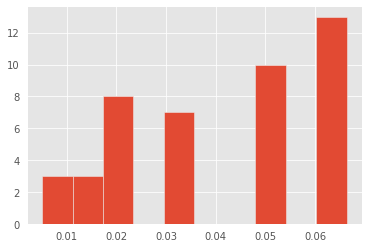

In [256]:
plt.hist(merged_cleaned_ps[merged_cleaned_ps['treatment'] == 1]['ps']);

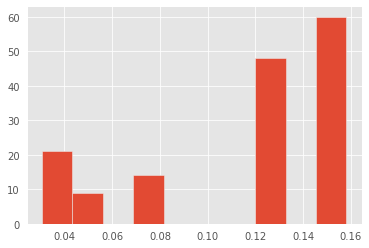

In [257]:
plt.hist(merged_cleaned_ps[merged_cleaned_ps['treatment'] == 0]['ps']);

In [258]:
treatment_yi = merged_cleaned_ps[merged_cleaned_ps["treatment"] == 1]["DataValue"]
treatment_e = merged_cleaned_ps[merged_cleaned_ps["treatment"] == 1]["ps"]
control_yi = merged_cleaned_ps[merged_cleaned_ps["treatment"] == 0]["DataValue"]
control_e = merged_cleaned_ps[merged_cleaned_ps["treatment"] == 0]["ps"]

ipw_estimate = np.mean(treatment_yi / treatment_e) - np.mean(control_yi / (1 - control_e)) # TODO (You might need several lines)
ipw_estimate

319.5305952469072

In [264]:
# It is better to include only propensity score beteween 0.1 to 0.9
cleaned_ps = merged_cleaned_ps[(merged_cleaned_ps["ps"] > 0.05) & (merged_cleaned_ps["ps"] < 0.9)]
cleaned_ps

,statefips,year,ds_pm_pred,ds_pm_stdd,stname,LocationAbbr,DataValue,Division,treatment,ps
0,1,2011,10.696324,3.159462,Alabama,AL,8.0,East South Central,1,0.051020
1,1,2012,10.396601,4.228621,Alabama,AL,8.5,East South Central,1,0.051020
2,1,2013,10.039805,4.201070,Alabama,AL,8.5,East South Central,1,0.051020
3,1,2014,11.007064,5.885860,Alabama,AL,9.5,East South Central,1,0.051020
4,10,2011,9.671609,2.614125,Delaware,DE,10.0,South Atlantic,0,0.147959
...,...,...,...,...,...,...,...,...,...,...
191,8,2014,6.674491,3.114788,Colorado,CO,8.3,Mountain,0,0.158163
192,9,2011,9.284398,2.494633,Connecticut,CT,10.1,New England,0,0.122449
193,9,2012,8.072119,2.612901,Connecticut,CT,10.1,New England,0,0.122449
194,9,2013,8.406929,2.795787,Connecticut,CT,10.0,New England,0,0.122449


In [266]:
treatment_yi_cleaned = cleaned_ps[cleaned_ps["treatment"] == 1]["DataValue"]
treatment_e_cleaned = cleaned_ps[cleaned_ps["treatment"] == 1]["ps"]
control_yi_cleaned = cleaned_ps[cleaned_ps["treatment"] == 0]["DataValue"]
control_e_cleaned = cleaned_ps[cleaned_ps["treatment"] == 0]["ps"]

ipw_estimate_cleaned = np.mean(treatment_yi_cleaned / treatment_e_cleaned) - np.mean(control_yi_cleaned / (1 - control_e_cleaned)) # TODO (You might need several lines)
ipw_estimate_cleaned

150.44815793290323

# Adding a time lag (which does not help)

Since the effect of PM2.5 concentration is not something that will show evidently, I tried to use asthma incidence a few years later and investigate wehther there is a relationship. 

The result however, is not evident. The correlation remian pretty low. 

In [213]:
age_asthma_overall

,YearStart,YearEnd,LocationAbbr,LocationDesc,DataSource,Topic,Question,Response,DataValueUnit,DataValueType,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1,StratificationCategory2,Stratification2,StratificationCategory3,Stratification3,ResponseID,LocationID,TopicID,QuestionID,DataValueTypeID,StratificationCategoryID1,StratificationID1,StratificationCategoryID2,StratificationID2,StratificationCategoryID3,StratificationID3,State,State Code,Region,Division
436,2019,2019,AL,Alabama,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Age-adjusted Prevalence,9.4,9.4,NaN,NaN,8.5,10.5,Overall,Overall,NaN,NaN,NaN,NaN,NaN,1,AST,AST1_1,AGEADJPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central
447,2015,2015,AL,Alabama,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Age-adjusted Prevalence,9.9,9.9,NaN,NaN,8.9,10.9,Overall,Overall,NaN,NaN,NaN,NaN,NaN,1,AST,AST1_1,AGEADJPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central
457,2017,2017,AL,Alabama,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Age-adjusted Prevalence,10.9,10.9,NaN,NaN,9.8,12.1,Overall,Overall,NaN,NaN,NaN,NaN,NaN,1,AST,AST1_1,AGEADJPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central
463,2013,2013,AL,Alabama,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Age-adjusted Prevalence,8.5,8.5,NaN,NaN,7.6,9.6,Overall,Overall,NaN,NaN,NaN,NaN,NaN,1,AST,AST1_1,AGEADJPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central
467,2011,2011,AL,Alabama,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Age-adjusted Prevalence,8.0,8.0,NaN,NaN,7.1,9.0,Overall,Overall,NaN,NaN,NaN,NaN,NaN,1,AST,AST1_1,AGEADJPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Alabama,AL,South,East South Central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60789,2016,2016,ME,Maine,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Age-adjusted Prevalence,12.7,12.7,NaN,NaN,11.5,14.0,Overall,Overall,NaN,NaN,NaN,NaN,NaN,23,AST,AST1_1,AGEADJPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Maine,ME,Northeast,New England
60808,2018,2018,ME,Maine,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Age-adjusted Prevalence,12.8,12.8,NaN,NaN,11.5,14.1,Overall,Overall,NaN,NaN,NaN,NaN,NaN,23,AST,AST1_1,AGEADJPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Maine,ME,Northeast,New England
60835,2012,2012,ME,Maine,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Age-adjusted Prevalence,11.3,11.3,NaN,NaN,10.4,12.2,Overall,Overall,NaN,NaN,NaN,NaN,NaN,23,AST,AST1_1,AGEADJPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Maine,ME,Northeast,New England
60848,2014,2014,ME,Maine,BRFSS,Asthma,Current asthma prevalence among adults aged >=...,NaN,%,Age-adjusted Prevalence,11.9,11.9,NaN,NaN,10.9,13.0,Overall,Overall,NaN,NaN,NaN,NaN,NaN,23,AST,AST1_1,AGEADJPREV,OVERALL,OVR,NaN,NaN,NaN,NaN,Maine,ME,Northeast,New England


In [214]:
age_asthma_overall_2012_2015 = age_asthma_overall[age_asthma_overall["YearStart"].isin(["2016", "2017", "2018", "2019"])]

In [215]:
age_asthma_overall_2012_2015_select = age_asthma_overall_2012_2015[["YearStart", "LocationAbbr", "LocationDesc", "DataValue", "Division"]]

In [216]:
age_asthma_overall_2012_2015_select

,YearStart,LocationAbbr,LocationDesc,DataValue,Division
436,2019,AL,Alabama,9.4,East South Central
457,2017,AL,Alabama,10.9,East South Central
493,2016,AL,Alabama,9.8,East South Central
501,2018,AL,Alabama,10.4,East South Central
1728,2017,AZ,Arizona,9.7,Mountain
...,...,...,...,...,...
59638,2016,SD,South Dakota,6.0,West North Central
60708,2017,ME,Maine,11.2,New England
60789,2016,ME,Maine,12.7,New England
60808,2018,ME,Maine,12.8,New England


In [217]:
PM_2point5["year_lag"] = PM_2point5["year"] + 5

In [218]:
PM_2point5

,statefips,year,ds_pm_pred,ds_pm_stdd,stname,st,stusps,year_lag
0,1,2011,10.696324,3.159462,Alabama,1,AL,2016
1,1,2012,10.396601,4.228621,Alabama,1,AL,2017
2,1,2013,10.039805,4.201070,Alabama,1,AL,2018
3,1,2014,11.007064,5.885860,Alabama,1,AL,2019
4,10,2011,9.671609,2.614125,Delaware,10,DE,2016
...,...,...,...,...,...,...,...,...
191,8,2014,6.674491,3.114788,Colorado,8,CO,2019
192,9,2011,9.284398,2.494633,Connecticut,9,CT,2016
193,9,2012,8.072119,2.612901,Connecticut,9,CT,2017
194,9,2013,8.406929,2.795787,Connecticut,9,CT,2018


In [219]:
merged_lag = PM_2point5.merge(age_asthma_overall_2012_2015_select, left_on = ["year_lag", "stname"], right_on =["YearStart", "LocationDesc"])

In [220]:
merged_lag_cleaned = merged_lag.drop([" stusps", "YearStart", "LocationDesc", " st", "year"], axis = 1)

In [221]:
merged_lag_cleaned

,statefips,ds_pm_pred,ds_pm_stdd,stname,year_lag,LocationAbbr,DataValue,Division
0,1,10.696324,3.159462,Alabama,2016,AL,9.8,East South Central
1,1,10.396601,4.228621,Alabama,2017,AL,10.9,East South Central
2,1,10.039805,4.201070,Alabama,2018,AL,10.4,East South Central
3,1,11.007064,5.885860,Alabama,2019,AL,9.4,East South Central
4,10,9.671609,2.614125,Delaware,2016,DE,8.7,South Atlantic
...,...,...,...,...,...,...,...,...
191,8,6.674491,3.114788,Colorado,2019,CO,9.7,Mountain
192,9,9.284398,2.494633,Connecticut,2016,CT,10.6,New England
193,9,8.072119,2.612901,Connecticut,2017,CT,10.9,New England
194,9,8.406929,2.795787,Connecticut,2018,CT,10.1,New England


In [222]:
merged_lag_cleaned["DataValue"].corr(merged_lag_cleaned["ds_pm_pred"])

-0.08279099895280699

Text(0.5, 1.0, 'PM 2.5 concentration vs. asthma incidence colored by region')

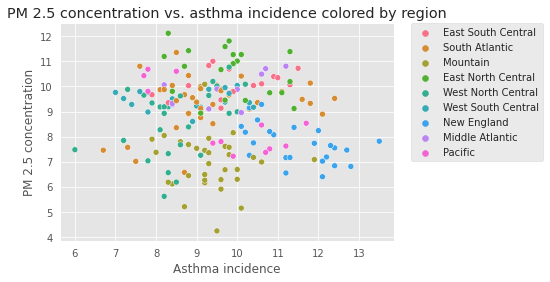

In [223]:
import seaborn as sns 
sns.scatterplot(x='DataValue',  y='ds_pm_pred', data=merged_lag_cleaned, hue="Division")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Asthma incidence")
plt.ylabel("PM 2.5 concentration")
plt.title("PM 2.5 concentration vs. asthma incidence colored by region")

# Hypothesis Testing

Null Hypothesis: In terms of avarage age adjusted asthma prevelance, there is no difference between divisionX and the rest of the population. IE the mean of the group from divisionX is equivalent to the mean from an equally sized group drawn from the population as a whole.

In [224]:
aap

,year,state,div,aap
0,2019,AL,East South Central,9.4
1,2015,AL,East South Central,9.9
2,2017,AL,East South Central,10.9
3,2013,AL,East South Central,8.5
4,2011,AL,East South Central,8.0
...,...,...,...,...
454,2016,ME,New England,12.7
455,2018,ME,New England,12.8
456,2012,ME,New England,11.3
457,2014,ME,New England,11.9


In [225]:
overall_mean = np.mean(aap["aap"])

division_means = aap.groupby("div").agg(np.mean)
division_counts = aap.groupby("div").count()

division_means["count"] = division_counts["aap"]
division_means

,year,aap,count
div,,,
East North Central,2015,9.777778,45
East South Central,2015,9.322222,36
Middle Atlantic,2015,9.469231,26
Mountain,2015,9.077778,72
New England,2015,11.250000,54
Pacific,2015,9.477778,45
South Atlantic,2015,9.146914,81
West North Central,2015,8.365079,63
West South Central,2015,8.519444,36


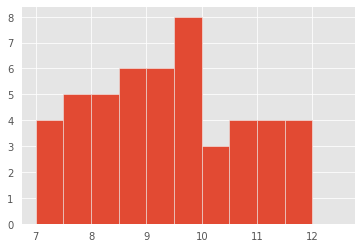

In [226]:
size = division_means.iloc[4,2]

actual_mean = division_means.iloc[4,1]

prevs = np.array(aap["aap"])
boot_means = []
for _ in np.arange(2000):
  boot = np.random.choice(prevs, replace = True, size = size )
  boot_means.append(np.mean(boot))

plt.hist(boot, bins = np.arange(7,13,0.5));
#plt.plot(actual_mean);

